# Sentiment Analysis
- NCCU PyDay 2022: https://www.facebook.com/groups/pythontw/posts/10162007038723438/
- Author: TENG-LIN YU
- Email: tlyu0419@gmail.com
- Github: https://github.com/TLYu0419/Stock-Prediction-Using-Facebook-Sentiment-with-Python

## Import packages

In [118]:
# !pip install jieba
# !pip install snownlp
# !pip install nltk
# !pip install translate
# !pip install seaborn

# pip install -U spacy
# python -m spacy download zh_core_web_md

In [149]:
import pandas as pd
import numpy as np
import os
import re
import json
import jieba
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from snownlp import SnowNLP
from translate import Translator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import spacy
from sklearn import svm
sns.set(rc={'figure.figsize':(16.7,8.27)})

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
path = '/home/tlyu0419/github/facebook_crawler/develop/data/'
df = pd.DataFrame()
for file in os.listdir(path):
    if 'pkl' in file:
        # print(file)
        ndf = pd.read_pickle(path + file)
        df = pd.concat([df, ndf], ignore_index=True)
        df = df.sort_values('UPDATETIME', ascending=False)
        df = df.drop_duplicates('POSTID', ignore_index=True)
print(df.shape)
df.head(5)

(48601, 19)


,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,URL,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY,UPDATETIME
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,114062348679049,2,20,5,2,AQHRj5aTJiNqyTYfX6UCGlNrhsEw3GvWhOtSOUVNUICabb...,https://www.facebook.com/YahooTWFinance/,19.0,0.0,0.0,0.0,1.0,0.0,0.0,2022-05-02 01:04:33
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣！遇到這些情況，賣掉反而更賺👍\n\n#投資 #存股族 #定存股 #出場時機,3670468989705016,114062348679049,3,17,6,3,AQHRBFufHr3FwSGViAhljuEBiZhLBkVsbXpm3BcRtm68U4...,https://www.facebook.com/YahooTWFinance/,16.0,0.0,1.0,0.0,0.0,0.0,0.0,2022-05-02 01:04:33
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點，進場的是傻子？聽聽艾蜜莉怎麼說💬\n\n#投資 #萬五 #便宜價 #操作策略,3670338283051420,114062348679049,1,19,3,1,AQHRBG-7_KGH0xPwOQYKWOKsSvVNMOavvOome_AAIPBTaS...,https://www.facebook.com/YahooTWFinance/,18.0,0.0,0.0,0.0,1.0,0.0,0.0,2022-05-02 01:04:33
3,Yahoo奇摩股市理財,2021-01-26 14:31:42,太暖心了☺️醫護人員辛苦了💪\n\n#疫情 #摩斯漢堡 #挺醫護 #優惠活動,3652011034884145,114062348679049,0,18,0,0,AQHR6UChWcVhb0lXgNF5KxunHT0WQk9O8Nu4sQkCgBSMZ0...,https://www.facebook.com/YahooTWFinance/,18.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-02 01:04:33
4,Yahoo奇摩股市理財,2021-01-26 17:01:34,太血汗了吧😱\n\n#職場 #量販業 #唐吉訶德 #薪資行情,3652498701502045,114062348679049,0,24,0,0,AQHReK9NLq7mI1wL12bpeThIOFRcjrRQBwkHPg_lfdpTD-...,https://www.facebook.com/YahooTWFinance/,18.0,0.0,1.0,1.0,0.0,4.0,0.0,2022-05-02 01:04:33


In [3]:
df.to_csv('./data/fanspage_posts/fanspage_posts.csv', index=False)

In [21]:
df = pd.read_csv('./data/fanspage_posts/fanspage_posts.csv')
df

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,URL,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY,UPDATETIME
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,114062348679049,2,20,5,2,AQHRj5aTJiNqyTYfX6UCGlNrhsEw3GvWhOtSOUVNUICabb...,https://www.facebook.com/YahooTWFinance/,19.0,0.0,0.0,0.0,1.0,0.0,0.0,2022-05-02 01:04:33
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣！遇到這些情況，賣掉反而更賺👍\n\n#投資 #存股族 #定存股 #出場時機,3670468989705016,114062348679049,3,17,6,3,AQHRBFufHr3FwSGViAhljuEBiZhLBkVsbXpm3BcRtm68U4...,https://www.facebook.com/YahooTWFinance/,16.0,0.0,1.0,0.0,0.0,0.0,0.0,2022-05-02 01:04:33
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點，進場的是傻子？聽聽艾蜜莉怎麼說💬\n\n#投資 #萬五 #便宜價 #操作策略,3670338283051420,114062348679049,1,19,3,1,AQHRBG-7_KGH0xPwOQYKWOKsSvVNMOavvOome_AAIPBTaS...,https://www.facebook.com/YahooTWFinance/,18.0,0.0,0.0,0.0,1.0,0.0,0.0,2022-05-02 01:04:33
3,Yahoo奇摩股市理財,2021-01-26 14:31:42,太暖心了☺️醫護人員辛苦了💪\n\n#疫情 #摩斯漢堡 #挺醫護 #優惠活動,3652011034884145,114062348679049,0,18,0,0,AQHR6UChWcVhb0lXgNF5KxunHT0WQk9O8Nu4sQkCgBSMZ0...,https://www.facebook.com/YahooTWFinance/,18.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-05-02 01:04:33
4,Yahoo奇摩股市理財,2021-01-26 17:01:34,太血汗了吧😱\n\n#職場 #量販業 #唐吉訶德 #薪資行情,3652498701502045,114062348679049,0,24,0,0,AQHReK9NLq7mI1wL12bpeThIOFRcjrRQBwkHPg_lfdpTD-...,https://www.facebook.com/YahooTWFinance/,18.0,0.0,1.0,1.0,0.0,4.0,0.0,2022-05-02 01:04:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48596,東森財經,2022-04-06 13:50:10,#六月去海編：醫師也認為，輕症者在家，不見得是更差的選擇？\n\n#輕症 #在家隔離 #單日確診,4459603400808361,127254684043276,0,16,0,0,AQHRICVDxfMAljHKMPw9Y64fched98L5FJkpE-Gag0foxm...,https://www.facebook.com/ebcmoney/,15.0,0.0,0.0,0.0,1.0,0.0,0.0,2022-04-14 07:37:44
48597,東森財經,2022-04-06 15:18:59,夏天開冷氣沒問題\n「重點在節電」\n王美花:電費太便宜,4459764217458946,127254684043276,557,1029,48,432,AQHRhVFdmgKX3h1_RXBlLGw8ghNDWBSKYbZaMcXpiFB3t_...,https://www.facebook.com/ebcmoney/,434.0,0.0,244.0,32.0,1.0,7.0,311.0,2022-04-14 07:37:44
48598,東森財經,2022-03-15 17:15:15,4個月役期延長至1年?\n邱國正鬆口:\n公布後1年實施,4403112156457486,127254684043276,188,416,2,108,AQHR1DOWFXL6wtUdIYGtBLBJ1dauVRqliHn7nDOyvTGmUg...,https://www.facebook.com/ebcmoney/,322.0,2.0,77.0,7.0,2.0,0.0,6.0,2022-04-14 07:37:44
48599,東森財經,2022-03-01 23:45:01,貓貓編：大家也養過寵物雞嗎？\n舊寵母雞見新崽出生！狂啄欺負→變麻吉黏TT\n\n影片授權：...,4366369103465125,127254684043276,299,9073,412,206,AQHRi1OeIfSkIKMFqArt0EzVh3-ydE4zseM44OVCkUG2k0...,https://www.facebook.com/ebcmoney/,7853.0,976.0,177.0,27.0,39.0,0.0,1.0,2022-04-14 07:37:44


In [22]:
df['REACTION_COUNT'] = df['REACTION_COUNT'].astype('int')
df['COMMENT_COUNT'] = df['COMMENT_COUNT'].astype('int')
df['SHARE_COUNT'] = df['SHARE_COUNT'].astype('int')
df['DISPLAYCOMMENTCOUNT'] = df['DISPLAYCOMMENTCOUNT'].astype('int')

In [23]:
df['DATE'] = df['TIME'].apply(lambda x: x[:10])
df['YM'] = df['DATE'].apply(lambda x: x[:7])
df['HOUR'] = df['TIME'].apply(lambda x: x[10:13])
df.head(3)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,LOVE,HAHA,WOW,CARE,SAD,ANGRY,UPDATETIME,DATE,YM,HOUR
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,114062348679049,2,20,5,2,AQHRj5aTJiNqyTYfX6UCGlNrhsEw3GvWhOtSOUVNUICabb...,...,0.0,0.0,0.0,1.0,0.0,0.0,2022-05-02 01:04:33,2020-12-31,2020-12,15
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣！遇到這些情況，賣掉反而更賺👍\n\n#投資 #存股族 #定存股 #出場時機,3670468989705016,114062348679049,3,17,6,3,AQHRBFufHr3FwSGViAhljuEBiZhLBkVsbXpm3BcRtm68U4...,...,0.0,1.0,0.0,0.0,0.0,0.0,2022-05-02 01:04:33,2021-02-02,2021-02,14
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點，進場的是傻子？聽聽艾蜜莉怎麼說💬\n\n#投資 #萬五 #便宜價 #操作策略,3670338283051420,114062348679049,1,19,3,1,AQHRBG-7_KGH0xPwOQYKWOKsSvVNMOavvOome_AAIPBTaS...,...,0.0,0.0,0.0,1.0,0.0,0.0,2022-05-02 01:04:33,2021-02-02,2021-02,12


## EDA
- by 時間, 發文人的line plot，方便我們設定研究的時間範圍

### 貼文數-heatmap
-  https://plotly.com/python/heatmaps/

In [24]:
# 不同粉絲頁的每天有多少貼文
plotdf = df.groupby(['NAME', 'DATE']).size().reset_index(name='CNT')
plotdf['CNT'] = np.log(plotdf['CNT'])
plotdf = plotdf.pivot('NAME', 'DATE', 'CNT')
plotdf = plotdf.fillna(0)
plotdf

DATE,2020-12-24,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,...,2022-04-22,2022-04-23,2022-04-24,2022-04-25,2022-04-26,2022-04-27,2022-04-28,2022-04-29,2022-04-30,2022-05-01
NAME,,,,,,,,,,,,,,,,,,,,,
CMoney 理財寶,0.0,0.0,0.0,0.693147,1.098612,1.386294,1.098612,1.791759,0.000000,1.609438,...,3.178054,2.995732,2.772589,3.218876,3.178054,3.332205,3.295837,3.295837,2.944439,2.890372
MoneyDJ理財資訊,0.0,0.0,0.0,0.000000,1.386294,0.000000,0.000000,0.000000,2.197225,1.945910,...,2.197225,0.000000,0.000000,2.302585,2.397895,2.397895,2.708050,2.564949,0.000000,0.000000
Money錢,0.0,0.0,0.0,0.000000,1.098612,1.386294,1.386294,0.693147,1.098612,1.386294,...,2.564949,2.302585,2.484907,2.484907,2.484907,2.639057,2.772589,2.772589,2.564949,2.708050
Smart 智富月刊,0.0,0.0,0.0,0.000000,1.386294,1.098612,1.609438,1.386294,1.609438,1.609438,...,2.079442,2.197225,2.197225,2.197225,2.197225,2.197225,2.197225,2.302585,2.302585,2.302585
Yahoo奇摩股市理財,0.0,0.0,0.0,0.000000,1.386294,0.693147,0.693147,0.000000,1.609438,1.791759,...,3.713572,2.639057,2.639057,3.891820,3.871201,3.784190,3.784190,3.871201,2.639057,2.639057
iMoney 智富雜誌,0.0,0.0,0.0,0.000000,1.609438,1.945910,0.000000,0.000000,0.000000,0.000000,...,3.737670,3.637586,2.995732,3.258097,3.583519,3.367296,3.367296,3.637586,3.367296,2.302585
今周刊,0.0,0.0,0.0,0.000000,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,...,3.637586,3.044522,3.496508,3.688879,3.637586,3.713572,3.496508,3.688879,3.496508,3.367296
東森財經,0.0,0.0,0.0,0.000000,1.386294,1.386294,0.000000,0.000000,0.000000,0.000000,...,4.174387,3.688879,3.555348,4.234107,4.262680,4.262680,4.290459,4.158883,3.784190,3.465736
林恩如-飆股女王,0.0,0.0,0.0,0.693147,0.693147,0.000000,0.000000,0.000000,1.098612,0.000000,...,0.000000,0.693147,0.000000,0.693147,0.693147,0.693147,0.000000,1.386294,0.000000,0.000000


<AxesSubplot:xlabel='DATE', ylabel='NAME'>

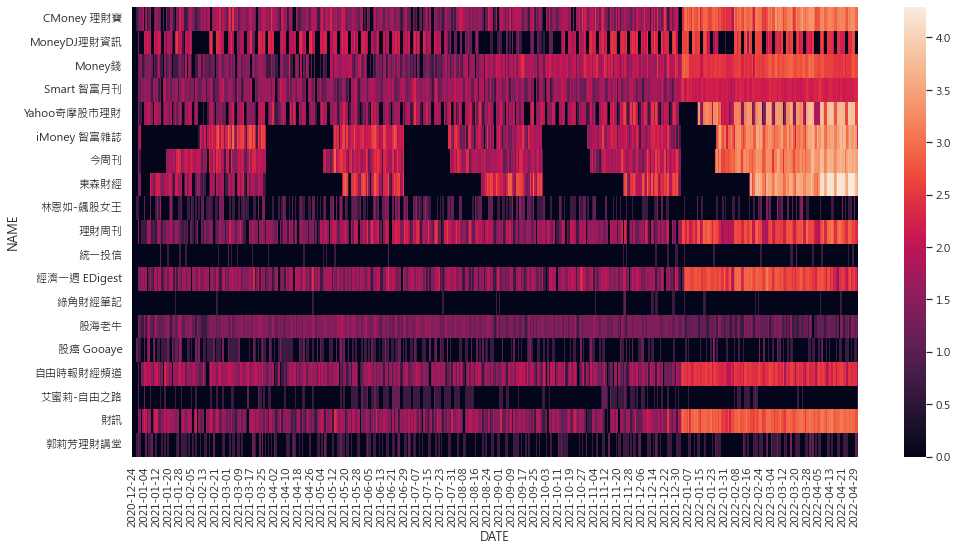

In [25]:
sns.heatmap(plotdf)

### 貼文數量與LIKE數 - scatter plot
- 初步檢視粉絲專頁的影響力

In [26]:
plotdf = df.groupby('NAME')['REACTION_COUNT'].describe()
plotdf

,count,mean,std,min,25%,50%,75%,max
NAME,,,,,,,,
CMoney 理財寶,3984.0,30.384789,85.171990,0.0,4.00,10.0,26.00,2776.0
MoneyDJ理財資訊,2632.0,46.836246,145.053563,0.0,14.00,22.0,36.00,3978.0
Money錢,3349.0,35.616602,127.443601,0.0,3.00,8.0,20.00,2420.0
Smart 智富月刊,2812.0,66.888336,108.566958,0.0,15.00,31.0,71.00,1564.0
Yahoo奇摩股市理財,4252.0,123.449200,511.532791,0.0,4.00,8.0,26.00,10406.0
iMoney 智富雜誌,4203.0,29.508684,109.562744,0.0,2.00,6.0,16.00,2517.0
今周刊,4272.0,347.195927,1206.060429,0.0,20.00,61.0,220.25,24210.0
東森財經,4556.0,939.789289,4498.118492,0.0,19.00,53.0,199.00,87487.0
林恩如-飆股女王,764.0,387.136126,261.085645,31.0,185.00,342.5,507.00,2475.0


<AxesSubplot:xlabel='count', ylabel='50%'>

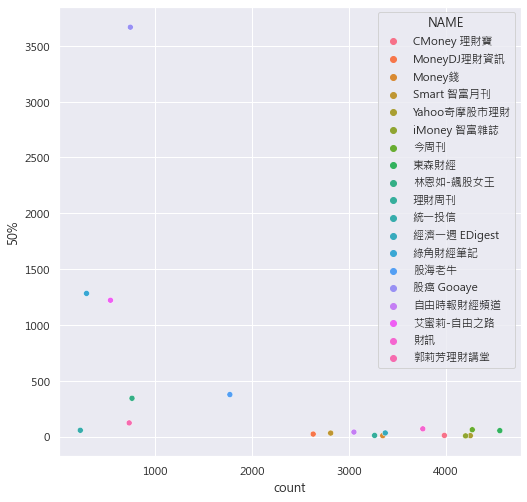

In [27]:
sns.set(rc={'figure.figsize':(8.27,8.27)})
sns.scatterplot(x='count', y='50%', data=plotdf, hue='NAME')

### 貼文字數-Boxplot

In [28]:
# 不同粉絲頁的貼文字數
df['MESSAGE_LEN'] = df['MESSAGE'].apply(lambda x: len(x))
df.groupby('NAME')['MESSAGE_LEN'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
NAME,,,,,,,,,,,,,,
CMoney 理財寶,3984.0,84.641817,99.866220,7.0,29.0,35.0,39.0,45.0,51.0,60.0,73.0,100.0,175.0,1517.0
MoneyDJ理財資訊,2632.0,166.283055,78.019981,42.0,106.0,118.0,128.0,138.0,148.0,159.0,172.7,192.0,233.0,984.0
Money錢,3349.0,65.628546,66.082169,12.0,28.0,33.0,37.0,41.0,46.0,52.0,60.0,77.0,127.0,714.0
Smart 智富月刊,2812.0,82.014225,134.575551,3.0,9.0,13.0,17.0,22.0,29.0,40.0,57.0,101.0,243.0,1016.0
Yahoo奇摩股市理財,4252.0,40.895343,36.072715,3.0,16.0,22.0,26.0,30.0,33.0,37.0,41.0,48.0,64.0,388.0
iMoney 智富雜誌,4203.0,183.456341,168.862384,11.0,31.0,39.0,49.0,57.0,73.0,262.0,308.0,345.6,394.0,1547.0
今周刊,4272.0,104.441245,96.862633,6.0,30.0,40.0,49.0,61.4,72.0,87.0,106.0,151.0,223.9,982.0
東森財經,4556.0,56.125988,36.236471,9.0,25.0,28.0,34.0,51.0,55.0,58.0,62.0,67.0,92.0,511.0
林恩如-飆股女王,764.0,165.061518,166.593210,4.0,16.0,33.6,59.9,87.0,113.0,146.0,203.1,276.4,389.0,1696.0


<AxesSubplot:xlabel='MESSAGE_LEN', ylabel='NAME'>

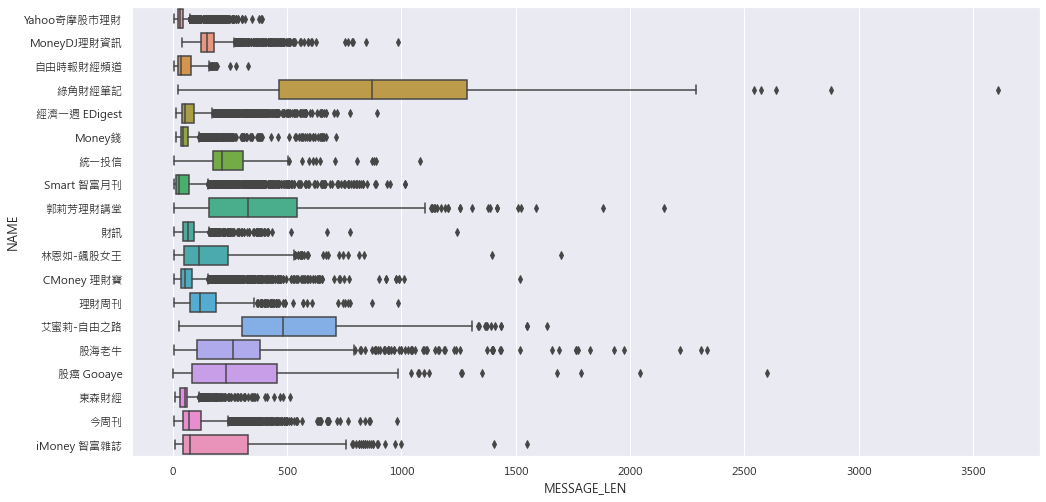

In [29]:
sns.set(rc={'figure.figsize':(16.27,8.27)})
sns.boxplot(x='MESSAGE_LEN', y='NAME', data=df[['NAME', 'MESSAGE', 'MESSAGE_LEN']])

### 字數跟按讚數- Regplot, hue by name

In [30]:
plotdf = df[['NAME', 'MESSAGE_LEN', 'REACTION_COUNT']]
plotdf['MESSAGE_LEN'] = np.log(plotdf['MESSAGE_LEN'])
plotdf['REACTION_COUNT'] = np.log(plotdf['REACTION_COUNT'])
plotdf

,NAME,MESSAGE_LEN,REACTION_COUNT
0,Yahoo奇摩股市理財,4.804021,2.995732
1,Yahoo奇摩股市理財,3.828641,2.833213
2,Yahoo奇摩股市理財,3.713572,2.944439
3,Yahoo奇摩股市理財,3.583519,2.890372
4,Yahoo奇摩股市理財,3.332205,3.178054
...,...,...,...
48596,東森財經,3.828641,2.772589
48597,東森財經,3.258097,6.936343
48598,東森財經,3.258097,6.030685
48599,東森財經,3.970292,9.113058


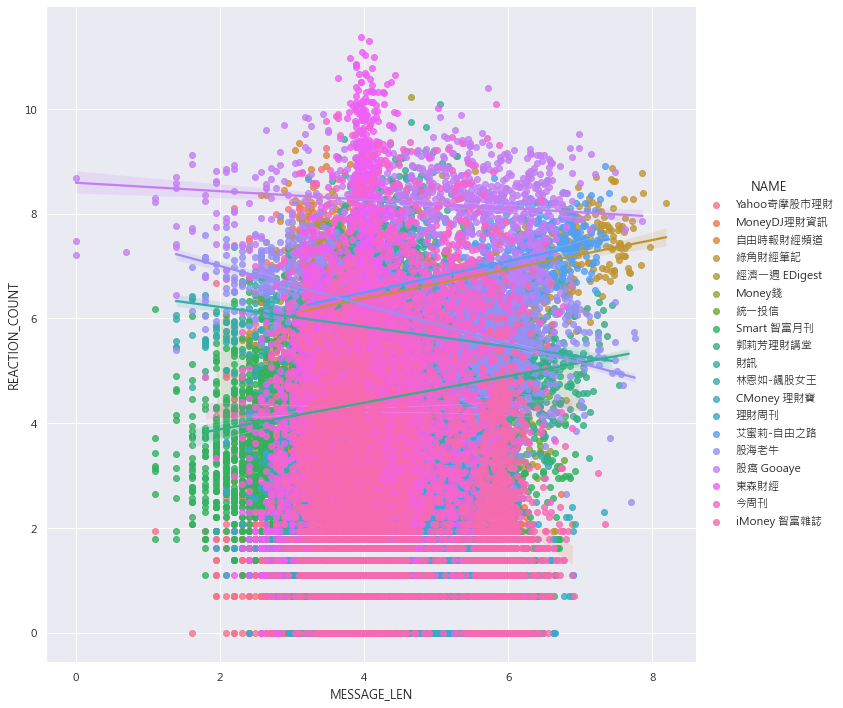

In [31]:
# sns.set(rc={'figure.figsize':(16, 16)})
sns.lmplot(x='MESSAGE_LEN', y='REACTION_COUNT', data = plotdf, hue='NAME', height=10)

### by小時的heatmap
- 透過這個分析可以知道爬蟲的時候要在什麼時間爬

In [32]:
plotdf = df[['NAME', 'HOUR']].groupby(['NAME', 'HOUR']).size().reset_index(name='COUNT')#.pivot('HOUR')
plotdf = plotdf.pivot(index='NAME', columns='HOUR', values='COUNT')
plotdf = plotdf.fillna(0)
plotdf

HOUR,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
NAME,,,,,,,,,,,,,,,,,,,,,
CMoney 理財寶,1.0,23.0,24.0,0.0,0.0,0.0,17.0,99.0,208.0,214.0,...,240.0,231.0,209.0,120.0,420.0,288.0,369.0,271.0,140.0,13.0
MoneyDJ理財資訊,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,25.0,233.0,...,202.0,197.0,201.0,183.0,202.0,224.0,251.0,115.0,21.0,2.0
Money錢,1.0,1.0,0.0,1.0,0.0,0.0,0.0,74.0,255.0,101.0,...,159.0,233.0,243.0,7.0,81.0,178.0,296.0,387.0,103.0,6.0
Smart 智富月刊,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,...,323.0,27.0,384.0,11.0,311.0,57.0,304.0,295.0,137.0,0.0
Yahoo奇摩股市理財,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,185.0,170.0,...,334.0,323.0,247.0,295.0,330.0,318.0,279.0,233.0,156.0,122.0
iMoney 智富雜誌,19.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,166.0,200.0,...,219.0,222.0,358.0,331.0,304.0,354.0,339.0,330.0,303.0,264.0
今周刊,3.0,0.0,1.0,0.0,0.0,0.0,2.0,78.0,191.0,252.0,...,330.0,290.0,262.0,289.0,288.0,289.0,271.0,257.0,254.0,120.0
東森財經,113.0,37.0,4.0,1.0,0.0,0.0,7.0,54.0,135.0,275.0,...,377.0,305.0,307.0,320.0,248.0,219.0,215.0,318.0,190.0,118.0
林恩如-飆股女王,13.0,8.0,0.0,0.0,0.0,0.0,0.0,3.0,32.0,56.0,...,43.0,35.0,36.0,89.0,48.0,37.0,82.0,71.0,27.0,28.0


<AxesSubplot:xlabel='HOUR', ylabel='NAME'>

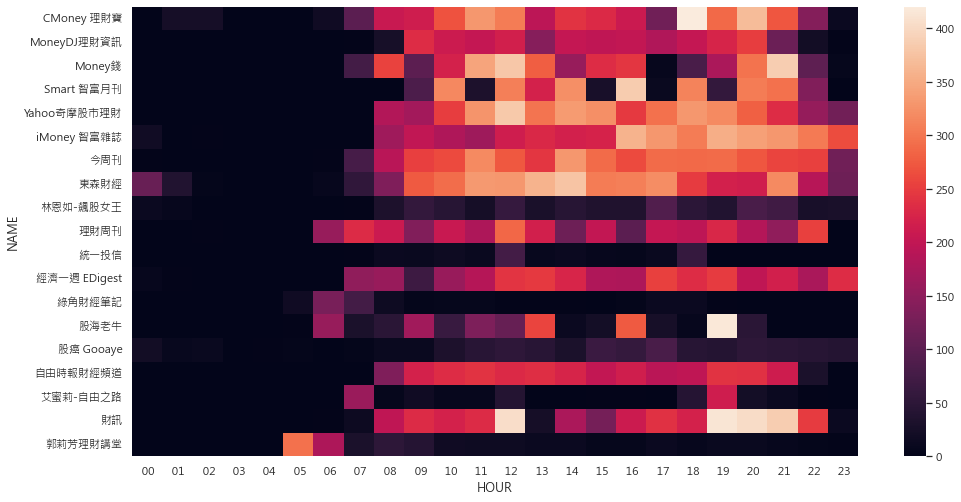

In [33]:
sns.heatmap(plotdf)

## 斷詞器

### 資料清理

In [34]:
stringliteral = 'https://www.yahoo.com.tw today'
re.sub(r'http\S+', '', stringliteral)

' today'

In [18]:
# remove http...
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub(r'http\S+', '', x))

# remove hash tag...
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub(r'#\S+', '', x))

# remove illegal multibyte ex: ❓🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[^\u4e00-\u9fa50-9A-Za-z\s+]', ' ', x))

# remove \n
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('\n', '', x))

# remove multiplt \s
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[\s+]{1,}', ' ', x))

### 手動新增
- jieba 的是詞庫是來自於1995年的人民日報訓練而得，一方面時間距今已久，另方面則是中國的語料庫，跟我們的習慣難免會不一樣，使用時可以適當的添加關鍵詞提升斷詞效果

In [41]:
sentence = df['MESSAGE'][9]
sentence

' 每年領現金的簡單投資法 今天的來賓收息投資專家MissQ她靠著3大收息資產 建立利滾利自動賺錢系統提早了20年退休不管你是小資族或是退休族 都可以像她一樣到底是哪三大收息資產 該怎麼挑選 來看看她的分享 有問題歡迎發問喔 李其展的外匯交易致勝兵法 '

In [42]:
np.array(jieba.lcut(sentence))

array([' ', '每年', '領現', '金', '的', '簡單', '投資法', ' ', '今天', '的', '來賓', '收息',
       '投資', '專家', 'MissQ', '她', '靠', '著', '3', '大收息', '資產', ' ', '建立',
       '利滾利', '自動', '賺', '錢', '系統', '提早', '了', '20', '年', '退休', '不管', '你',
       '是', '小資族', '或是', '退休', '族', ' ', '都', '可以', '像', '她', '一樣', '到底',
       '是', '哪三大', '收息', '資產', ' ', '該', '怎麼', '挑選', ' ', '來', '看看', '她',
       '的', '分享', ' ', '有', '問題', '歡迎', '發問', '喔', ' ', '李其展', '的', '外匯',
       '交易', '致勝', '兵法', ' '], dtype='<U5')

In [43]:
words = ['存股族', '資金', '瑞幸咖啡', '台中', '資產', '公開', '強強滾', '大盤', '覺得', '佈局', '宅女', '搶買', '投資', '上漲', '後悔', '房地產', 
         '以房養老', '留房養老', '殖利率', '佳世達', '公升', '無鉛汽油', '陳啟祥', '開始', '賺錢', '退休族']
for word in words:
    jieba.add_word(word)

In [44]:
np.array(jieba.lcut(sentence))

array([' ', '每年', '領現', '金', '的', '簡單', '投資', '法', ' ', '今天', '的', '來賓',
       '收息', '投資', '專家', 'MissQ', '她', '靠', '著', '3', '大收息', '資產', ' ',
       '建立', '利滾利', '自動', '賺錢', '系統', '提早', '了', '20', '年', '退休', '不管',
       '你', '是', '小資族', '或是', '退休族', ' ', '都', '可以', '像', '她', '一樣', '到底',
       '是', '哪三大', '收息', '資產', ' ', '該', '怎麼', '挑選', ' ', '來', '看看', '她',
       '的', '分享', ' ', '有', '問題', '歡迎', '發問', '喔', ' ', '李其展', '的', '外匯',
       '交易', '致勝', '兵法', ' '], dtype='<U5')

In [45]:
df['PROC_MESSAGE'] = df['MESSAGE'].apply(lambda x: jieba.lcut(x))
df.head(3)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,WOW,CARE,SAD,ANGRY,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,台積電 鴻海還會漲 分析師解答你的投資疑難雜症 今年台股強強滾 明年看好哪些股票 明年台股...,416134436394373,114062348679049,2,20,5,2,AQHRj5aTJiNqyTYfX6UCGlNrhsEw3GvWhOtSOUVNUICabb...,...,0.0,1.0,0.0,0.0,2022-05-02 01:04:33,2020-12-31,2020-12,15,122,"[ , 台積電, , 鴻海, 還會漲, , 分析, 師, 解答, 你, 的, 投資, 疑..."
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣 遇到這些情況 賣掉反而更賺,3670468989705016,114062348679049,3,17,6,3,AQHRBFufHr3FwSGViAhljuEBiZhLBkVsbXpm3BcRtm68U4...,...,0.0,0.0,0.0,0.0,2022-05-02 01:04:33,2021-02-02,2021-02,14,46,"[存股族, 別, 真的, 抱著, 不賣, , 遇到, 這些, 情況, , 賣掉, 反而,..."
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點 進場的是傻子 聽聽艾蜜莉怎麼說,3670338283051420,114062348679049,1,19,3,1,AQHRBG-7_KGH0xPwOQYKWOKsSvVNMOavvOome_AAIPBTaS...,...,0.0,1.0,0.0,0.0,2022-05-02 01:04:33,2021-02-02,2021-02,12,41,"[股市, 高點, , 進場, 的, 是, 傻子, , 聽, 聽, 艾蜜莉, 怎麼, 說, ]"


In [46]:
for sent in df['PROC_MESSAGE'][:5]:
    print(sent)
    print('====')

[' ', '台積電', ' ', '鴻海', '還會漲', ' ', '分析', '師', '解答', '你', '的', '投資', '疑難', '雜症', ' ', '今年', '台股', '強強滾', ' ', '明年', '看好', '哪些', '股票', ' ', '明年', '台股', '展望', '如何', ' ', '拿到', '年', '終獎', '金', ' ', '可以', '投資', '到', '哪裡', '呢', ' ', '有', '任何', '投資', '問題', ' ', '分析', '師幫', '你', '解答', ' ', '有', '問題', '歡迎', '發問', '喔', ' ', '葉芷娟', ' ', '李其展', '的', '外匯', '交易', '致勝', '兵法']
====
['存股族', '別', '真的', '抱著', '不賣', ' ', '遇到', '這些', '情況', ' ', '賣掉', '反而', '更', '賺', ' ']
====
['股市', '高點', ' ', '進場', '的', '是', '傻子', ' ', '聽', '聽', '艾蜜莉', '怎麼', '說', ' ']
====
['太暖心', '了', ' ', '醫護', '人員', '辛苦', '了', ' ']
====
['太', '血汗', '了', '吧', ' ']
====


### ngram

In [47]:
df['PROC_MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[^\u4e00-\u9fa5]', '', x))
count_vect = CountVectorizer(ngram_range=(2,6), analyzer='char', max_features=50) # analyzer{‘word’, ‘char’, ‘char_wb’} or callable, default=’word’
bow_rep = count_vect.fit_transform(df['PROC_MESSAGE'])
count_vect.vocabulary_.keys()

dict_keys(['台積', '積電', '的投', '投資', '今年', '台股', '股票', '如何', '可以', '台積電', '的投資', '真的', '股市', '怎麼', '台灣', '全球', '大家', '指數', '美國', '資人', '現在', '理財', '投資人', '還是', '獲利', '可能', '不是', '國際', '什麼', '自己', '沒有', '中國', '如果', '股價', '市場', '利率', '因為', '的人', '開始', '公司', '疫情', '就是', '一個', '知道', '時間', '我們', '經濟', '成長', '更多', '智富'])

In [17]:
# for word in count_vect.vocabulary_.keys():
#     jieba.add_word(word)

## 情感分析

### 統計值法

In [259]:
df = pd.read_csv('./data/fanspage_posts/fanspage_posts.csv')
df = df[['NAME', 'TIME', 'MESSAGE', 'POSTID', 'LIKE', 'LOVE', 'HAHA', 'WOW', 'CARE', 'SAD', 'ANGRY']]
df['DATE'] = df['TIME'].apply(lambda x: x[:10])
df.head(3)

,NAME,TIME,MESSAGE,POSTID,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY,DATE
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,19.0,0.0,0.0,0.0,1.0,0.0,0.0,2020-12-31
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣！遇到這些情況，賣掉反而更賺👍\n\n#投資 #存股族 #定存股 #出場時機,3670468989705016,16.0,0.0,1.0,0.0,0.0,0.0,0.0,2021-02-02
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點，進場的是傻子？聽聽艾蜜莉怎麼說💬\n\n#投資 #萬五 #便宜價 #操作策略,3670338283051420,18.0,0.0,0.0,0.0,1.0,0.0,0.0,2021-02-02


In [260]:
fb_sent = df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()
fb_sent = fb_sent.reset_index()
fb_sent

,DATE,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
0,2020-12-24,199.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2020-12-28,1256.0,0.0,14.0,4.0,1.0,0.0,0.0
2,2020-12-29,3158.0,21.0,21.0,3.0,2.0,0.0,2.0
3,2020-12-30,9667.0,541.0,55.0,309.0,10.0,0.0,13.0
4,2020-12-31,15031.0,684.0,210.0,64.0,26.0,29.0,12.0
...,...,...,...,...,...,...,...,...
486,2022-04-27,108448.0,14817.0,707.0,3268.0,326.0,369.0,1409.0
487,2022-04-28,89731.0,5628.0,2944.0,1104.0,735.0,252.0,11873.0
488,2022-04-29,134649.0,18585.0,1300.0,5173.0,366.0,206.0,264.0
489,2022-04-30,53472.0,18303.0,502.0,577.0,485.0,165.0,407.0


In [261]:
os.makedirs('./data/fb_sent', exist_ok=True)
fb_sent.to_csv('./data/fb_sent/fb_sent.csv', index=False)

### 詞典法
- 缺點是通用的情感詞典無法適用特定的情境

In [56]:
# https://www.msn.com/zh-tw/entertainment/news/joeman%E9%96%8B%E8%B5%B7%E8%96%AA4%E8%90%AC%E5%BE%B5%E6%89%8D%E6%8C%A8%E8%BD%9F-%E6%85%A3%E8%80%81%E9%97%86-%E6%9C%AC%E4%BA%BA%E5%9B%9E%E6%87%89%E4%BA%86/ar-AAWODyd
sentence = 'Joeman開起薪4萬徵才挨轟「慣老闆」 本人回應了'
jieba.lcut(sentence)

['Joeman',
 '開起薪',
 '4',
 '萬徵才',
 '挨',
 '轟',
 '「',
 '慣老',
 '闆',
 '」',
 ' ',
 '本人',
 '回應',
 '了']

#### 台大情感詞庫
  - http://rportal.lib.ntnu.edu.tw/bitstream/20.500.12235/80604/1/ntnulib_ja_A1021_4401_024.pdf
  - https://www.rdocumentation.org/packages/tmcn/versions/0.2-13/topics/NTUSD
  - https://rdrr.io/rforge/tmcn/

In [50]:
# NTUSD
neg_words = pd.read_csv('./sent_dict/NTUSD_traditional/NTUSD_negative_unicode.txt', header=None)[0].to_list()
print(neg_words[:30])
print('=============')
pos_words = pd.read_csv('./sent_dict/NTUSD_traditional/NTUSD_positive_unicode.txt', header=None)[0].to_list()
print(pos_words[:30])

['一下子爆發', '一下子爆發的一連串', '一巴掌', '一再', '一再叮囑', '一拳', '一般殺人罪', '一陣狂風', '一陣緊張', '一掌', '一團糟', '一摑', '一點點', '一蹶不振', '人事不省', '人為', '人為的', '入迷', '入迷的', '入迷的人', '刀刃', '刁難', '力盡', '匕首', '下地獄', '下垂', '下垂度', '下流', '下流的', '下降']
['一帆風順', '一帆風順的', '一流', '一致', '一致的', '了不起', '了不起的', '了解', '人性', '人性的', '人格高尚', '人格高尚的', '人情', '人情味', '入神', '入神的', '入迷', '入迷的', '上好', '上好的', '上等', '上等的', '口頭通過', '大方', '大方的', '大無畏', '大無畏的', '大量的', '大膽', '大膽的']


In [57]:
def sent_score(sent, pos_words, neg_words):
    pos_score = 0
    neg_score = 0
    seg = jieba.lcut(sent)
    print(seg)
    for word in seg:
        if word in pos_words:
            pos_score = pos_score + 1
        if word in neg_words:
            neg_score = neg_score + 1
    return pos_score, neg_score

In [58]:
sentence = '我以為今天的天氣很好但現實給了我一拳'
sent_score(sent = sentence, pos_words=pos_words, neg_words=neg_words)

['我', '以', '為', '今天', '的', '天氣', '很', '好', '但', '現實給', '了', '我', '一拳']


(0, 1)

#### 大連理工大學
  - https://github.com/ZaneMuir/DLUT-Emotionontology
  - 情感语料库的构建和分析 徐琳宏 ,林鸿飞 ,赵 晶

In [59]:
sentment_keywords = pd.read_excel('./sent_dict/情感词汇本体/情感词汇本体.xlsx')
sentment_keywords.groupby('情感分类').head(2)

,词语,词性种类,词义数,词义序号,情感分类,强度,极性,辅助情感分类,强度.1,极性.1,Unnamed: 10,Unnamed: 11
0,脏乱,adj,1.0,1.0,NN,7,2,NaN,NaN,NaN,NaN,NaN
1,糟报,adj,1.0,1.0,NN,5,2,NaN,NaN,NaN,NaN,NaN
2,早衰,adj,1.0,1.0,NE,5,2,NaN,NaN,NaN,NaN,NaN
5,战祸,noun,1.0,1.0,ND,5,2,NC,5.0,2.0,NaN,NaN
7,折辱,noun,1.0,1.0,NE,5,2,NN,5.0,2.0,NaN,NaN
9,清峻,adj,1.0,1.0,PH,5,0,NaN,NaN,NaN,NaN,NaN
10,清莹,adj,1.0,1.0,PH,5,1,NaN,NaN,NaN,NaN,NaN
18,瑞雪,noun,1.0,1.0,PA,5,1,NaN,NaN,NaN,NaN,NaN
19,擅名,noun,1.0,1.0,PD,7,1,NaN,NaN,NaN,NaN,NaN
20,神采,adj,1.0,1.0,PA,5,1,PH,1.0,1.0,NaN,NaN


#### 自定義關鍵詞
- 可以從別人開源過的資料拿來改，經過多輪的反覆循環進行優化

In [60]:
neg_words = ['跳空', '競爭', '懷疑', '庫存', '封城', '憂心']
pos_words = ['強勢', '傑出', '解決', '上漲']

In [61]:
sentence = '台積電的股價強勢上漲但是上海的封城令人憂心'
sent_score(sent = sentence, pos_words=pos_words, neg_words=neg_words)

['台積電', '的', '股價', '強勢', '上漲', '但是', '上海', '的', '封城', '令人', '憂心']


(2, 2)

### 套件法
- 英文的可以看NLTK
- 但是要留意準確度的問題，因為每個人要應用的場景不會完全相同

#### NLTK

In [62]:
# NLTK
sentence = '''
It was one of the worst movies I've seen, despite good reviews. 
Unbelievably bad acting!! Poor direction. VERY poor production. 
The movie was bad. Very bad movie. VERY bad movie. VERY BAD movie. VERY BAD movie!
'''
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.609, 'neu': 0.391, 'pos': 0.0, 'compound': -0.9921}

#### SnowNLP
- 訓練的語料庫來自中國飯店的評論資料

In [63]:
s = SnowNLP('這個東西真的很棒')
s.sentiments

0.8587303470185047

In [69]:
df2 =  df[['NAME', 'DATE', 'MESSAGE', 'POSTID']]
df2 = df2.loc[df2['MESSAGE'].apply(lambda x: len(x)>2)]
df2['SnowNLP_sent'] = df2['MESSAGE'].apply(lambda x: SnowNLP(x).sentiments)
df2

,NAME,DATE,MESSAGE,POSTID,SnowNLP_sent
0,Yahoo奇摩股市理財,2020-12-31,台積電 鴻海還會漲 分析師解答你的投資疑難雜症 今年台股強強滾 明年看好哪些股票 明年台股...,416134436394373,0.002964
1,Yahoo奇摩股市理財,2021-02-02,存股族別真的抱著不賣 遇到這些情況 賣掉反而更賺,3670468989705016,0.257444
2,Yahoo奇摩股市理財,2021-02-02,股市高點 進場的是傻子 聽聽艾蜜莉怎麼說,3670338283051420,0.046384
3,Yahoo奇摩股市理財,2021-01-26,太暖心了 醫護人員辛苦了,3652011034884145,0.940763
4,Yahoo奇摩股市理財,2021-01-26,太血汗了吧,3652498701502045,0.190888
...,...,...,...,...,...
48595,東森財經,2022-03-17,7歲兒賭氣拒坐車 虎媽1招教育 必須狠下心影片來源 白鹿視頻,4408310619270973,0.000088
48597,東森財經,2022-04-06,夏天開冷氣沒問題 重點在節電 王美花 電費太便宜,4459764217458946,0.000251
48598,東森財經,2022-03-15,4個月役期延長至1年 邱國正鬆口 公布後1年實施,4403112156457486,0.060806
48599,東森財經,2022-03-01,貓貓編 大家也養過寵物雞嗎 舊寵母雞見新崽出生 狂啄欺負 變麻吉黏TT影片授權 聿馡Camilla,4366369103465125,0.136806


In [71]:
snownlp_sent = df2.groupby('DATE')['SnowNLP_sent'].mean().reset_index(name='SnowNLP_sent')
snownlp_sent

,DATE,SnowNLP_sent
0,2020-12-24,2.647088e-06
1,2020-12-28,4.999927e-01
2,2020-12-29,4.152456e-11
3,2020-12-30,2.932701e-01
4,2020-12-31,3.485937e-01
...,...,...
486,2022-04-27,3.128470e-01
487,2022-04-28,3.433799e-01
488,2022-04-29,3.081356e-01
489,2022-04-30,3.263252e-01


In [72]:
os.makedirs('./data/snownlp_sent',  exist_ok=True)
snownlp_sent.to_csv('./data/snownlp_sent/snownlp_sent.csv', index=False)

### 翻譯法
- deepl: https://www.deepl.com/translator

In [73]:
# 最困難的不是面對挫折打擊，最困難的是面對各種挫折打擊，卻沒有失去對人世的熱情
translation = 'The most difficult thing is not to face setbacks, the most difficult thing is to face all kinds of setbacks, but not to lose the enthusiasm for the world'
print(translation)

The most difficult thing is not to face setbacks, the most difficult thing is to face all kinds of setbacks, but not to lose the enthusiasm for the world


In [74]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(translation)

{'neg': 0.107, 'neu': 0.704, 'pos': 0.19, 'compound': 0.6052}

In [134]:
df2 = pd.read_excel('./data/deeplnltk/deepl.xlsx')
df2['DATE'] = df2['TIME'].apply(lambda x: x[:10])
df2 = df2[['NAME', 'DATE', 'MESSAGE', 'POSTID', 'MESSAGE_EN']]
df2.head(3)

,NAME,DATE,MESSAGE,POSTID,MESSAGE_EN
0,CMoney 理財寶,2021-03-19,近期 不論是美國還是台灣的 科技股都下跌了不少 但從數據回測 還是有機會讓 小資族 快速存好...,4058398430907687,"Recently, both the U.S. and Taiwan's technolog..."
1,CMoney 理財寶,2022-04-13,81XX 成交量爆歷史高收十字線 明天走勢會,5268325189914999,81XX volume exploded to a record high closing...
2,CMoney 理財寶,2021-12-10,不敗教主陳重銘 股海在走 知識真的要有 除非你是神仙 可以猜中股價的高低點 不然就乖乖跟我...,4857623530985169,Unless you are an immortal and can guess the ...


In [135]:
df2['DEEPNLTK_SENT'] = df2['MESSAGE_EN'].apply(lambda x: sia.polarity_scores(x))
df2['DEEPNLTK_POS'] = df2['DEEPNLTK_SENT'].apply(lambda x: x['pos'])
df2['DEEPNLTK_NEU'] = df2['DEEPNLTK_SENT'].apply(lambda x: x['neu'])
df2['DEEPNLTK_NEG'] = df2['DEEPNLTK_SENT'].apply(lambda x: x['neg'])
df2.head(5)

,NAME,DATE,MESSAGE,POSTID,MESSAGE_EN,DEEPNLTK_SENT,DEEPNLTK_POS,DEEPNLTK_NEU,DEEPNLTK_NEG
0,CMoney 理財寶,2021-03-19,近期 不論是美國還是台灣的 科技股都下跌了不少 但從數據回測 還是有機會讓 小資族 快速存好...,4058398430907687,"Recently, both the U.S. and Taiwan's technolog...","{'neg': 0.042, 'neu': 0.678, 'pos': 0.28, 'com...",0.28,0.678,0.042
1,CMoney 理財寶,2022-04-13,81XX 成交量爆歷史高收十字線 明天走勢會,5268325189914999,81XX volume exploded to a record high closing...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,1.000,0.000
2,CMoney 理財寶,2021-12-10,不敗教主陳重銘 股海在走 知識真的要有 除非你是神仙 可以猜中股價的高低點 不然就乖乖跟我...,4857623530985169,Unless you are an immortal and can guess the ...,"{'neg': 0.069, 'neu': 0.731, 'pos': 0.2, 'comp...",0.20,0.731,0.069
3,CMoney 理財寶,2022-01-20,快訊 外資今日轉賣為買 24XX 開盤跳空上漲 大戶持續買超中 你還沒跟上,5016857888395065,News: Foreign investors turned from selling t...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,1.000,0.000
4,CMoney 理財寶,2022-04-15,快訊 受惠疫情加劇 他 大戶散戶合力買 跳空大漲逾8 直攻漲停,5272520269495491,The large retail investors are buying togethe...,"{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'comp...",0.00,0.845,0.155


In [136]:
os.makedirs('./data/deeplnltk',  exist_ok=True)
df2.to_csv('./data/deeplnltk/deeplnltk.csv', index=False)

### 借模型法
- 分成對方提供的免費試用和正式提供的服務
- 百度: https://console.bce.baidu.com/ai/?_=1650861631579&fromai=1#/ai/nlp/app/list

#### wiser ai lab

In [72]:
url = 'https://www.wisers.ai/?api=ailab-demo-apilb.wisers.com:8000/senti/api/processtext'
data = {'text':'遭標普降評 俄瀕臨百年首見違約、威脅要告上法院',
        'model':'dl',
        'output_level':'subject',
        'show_scores':'true'}
resp = requests.post(url, json=data) 
resp.json()

{'docid': None,
 'is_successful': True,
 'message': '',
 'overall_res': {'sentiment': -1, 'sentiment_score': 0},
 'detail_res': []}

#### Baidu aidemo

In [84]:
url = 'https://ai.baidu.com/aidemo'
data = {'apiType': 'nlp', 
        'type': 'sentimentClassify',
        't1': '配置頂級，不解釋，手機需要的各個方面都很完美'}
headers = {'Referer': 'https://ai.baidu.com/tech/nlp_apply/sentiment_classify'}
resp = requests.post(url, data=data, headers=headers) 
resp.json()

{'errno': 0,
 'msg': 'success',
 'data': {'log_id': '8594565343129384354',
  'text': '配置頂級，不解釋，手機需要的各個方面都很完美',
  'items': [{'positive_prob': 0.99923,
    'confidence': 0.998289,
    'negative_prob': 0.000770009,
    'sentiment': 2}]}}

#### baidu-aip
- https://ai.baidu.com/tech/nlp_apply/sentiment_classify
- 註冊帳號可以體驗xx次，註冊時記得切換成英文模式才能用各國的手機號碼註冊
- 次数包售卖方式低至15元/万次

In [88]:
# !pip install baidu-aip
from aip import AipNlp
APP_ID = '25938061'
API_KEY = 'UzqA7VEKAsuHK5GOxvgRmFuM'
SECRET_KEY = 'W9lWRbTk4LG6VnnjQFFGXvFb2smdbkKc'

In [93]:
client = AipNlp(appId = APP_ID, apiKey=API_KEY, secretKey=SECRET_KEY)
text = '在大數據情感分析的幫助下，能夠準確的預測股價的走勢，成功賺大錢'
client.sentimentClassify(text)

{'log_id': 3139038312303046914,
 'text': '在大數據情感分析的幫助下，能夠準確的預測股價的走勢，成功賺大錢',
 'items': [{'positive_prob': 0.992052,
   'confidence': 0.982338,
   'negative_prob': 0.0079479,
   'sentiment': 2}]}

In [107]:
df2 = pd.read_csv('./data/baidu_sent/baidu_sent.csv')
df2.head(3)

,POSTID,MESSAGE,BAIDU_SENT
0,4058373284243535,談加薪 總是弄得戰戰兢兢 千萬別用 缺錢 個人開銷大 作為加薪理由 資方可不吃情感勒索這套,"{'log_id': 7395251777801488185, 'text': '談加薪 總..."
1,3924600430954155,庫存偏低 供貨縮減 DRAM 現貨近日價格全面急漲 法人看好 南亞科 2408 等 4 檔今...,"{'log_id': 9199660420116662489, 'text': '庫存偏低 ..."
2,5249051811842337,從老闆角度看 不願意提供員工高薪的原因很簡單 就是不值得為產值不高的員工付出更高的薪水 也就...,"{'log_id': 6165989481510872313, 'text': '從老闆角度..."


In [109]:
df2['BAIDU_POS'] = df2['BAIDU_SENT'].apply(lambda x: eval(x)['items'][0]['positive_prob'])
df2['BAIDU_NEG'] = df2['BAIDU_SENT'].apply(lambda x: eval(x)['items'][0]['negative_prob'])
df2 = df2[['POSTID', 'MESSAGE', 'BAIDU_POS', 'BAIDU_NEG']]
df2.head(5)

,POSTID,MESSAGE,BAIDU_POS,BAIDU_NEG
0,4058373284243535,談加薪 總是弄得戰戰兢兢 千萬別用 缺錢 個人開銷大 作為加薪理由 資方可不吃情感勒索這套,0.012472,0.987528
1,3924600430954155,庫存偏低 供貨縮減 DRAM 現貨近日價格全面急漲 法人看好 南亞科 2408 等 4 檔今...,0.197054,0.802946
2,5249051811842337,從老闆角度看 不願意提供員工高薪的原因很簡單 就是不值得為產值不高的員工付出更高的薪水 也就...,0.001304,0.998696
3,3990574971023367,原來 一毛不剩 才是最棒的存錢法,0.528559,0.471441
4,5236154306465421,投資股票 不想再繳學費 先看懂均線 用 4 招判斷買賣點 股市震盪也不怕獲利,0.040230,0.959770


In [110]:
df2.to_csv('./data/baidu_sent/baidu_sent_proc.csv', index=False)

### 模型法
- 如果有標註好的資料，就可以做很多事情，但標資料很累很辛苦
- Sentiment Analysis of Twitter Data: A Survey of Techniques
- 情感分析的準確度上限約77%

In [122]:
# ## 1=正向，-1=負向， 混合或其他的貼文就 0, 
# sent_df = []
# pos_cnt = 0
# neg_cnt = 0
# while True:
#     print('Progess >> positive count: {}/10, negative count: {}/10'.format(pos_cnt, neg_cnt))
#     rand = np.random.choice(df.shape[0])
#     print(df['NAME'][rand])
#     print(df['MESSAGE'][rand])
#     sent = input('Sentiment Score: ')
#     if sent == '1':
#         sent_df.append([df['PROC_MESSAGE'][rand], sent])
#         pos_cnt = pos_cnt + 1
#         print(pos_cnt)
#     if sent == '2':
#         sent_df.append([df['PROC_MESSAGE'][rand], sent])
#         neg_cnt = neg_cnt + 1
#     if pos_cnt >= 10 & neg_cnt >= 10:
#         break
#     clear_output()
# sent_df = pd.DataFrame(sent_df, columns=['PROC_MESSAGE', 'SENTIMENT'])
# sent_df

#### GooglePlay sample data
- label 資料非常少很辛苦，改借用別的資料集
- https://spacy.io/api/cli#download
- https://spacy.io/usage/models#download-pip

In [116]:
sent_df = pd.read_excel('./data/GooglePlay_Comments.xlsx')
sent_df

,Name,Timestamp,Content,Sentimen,likecounts
0,李宗翰,2020年6月29日,不錯,獲評為 5 顆星 (滿分 5 顆星),0
1,Ning Hsu,2020年6月29日,已經等了有一週了，還沒收到退費的簡訊通知，若我到銀行確認並無退費，那我會尋求法律幫助。（20...,獲評為 1 顆星 (滿分 5 顆星),13
2,宋佳宸,2020年6月29日,還不錯，挺方便的,獲評為 5 顆星 (滿分 5 顆星),0
3,翁嘉雯,2020年6月29日,好,獲評為 5 顆星 (滿分 5 顆星),0
4,蔡曜安,2020年6月29日,系統說外送員還在路上，但是實際上卻已經到了，讓外送員等我下樓真的很不好意思！,獲評為 2 顆星 (滿分 5 顆星),0
...,...,...,...,...,...
2795,曾小倩,2020年5月26日,越來越爛 這兩個月就遇到三次訂單問題 1.之前訂購兩張訂單，有一張訂單店家根本沒收到，白白等...,獲評為 1 顆星 (滿分 5 顆星),123
2796,Dino Leong,2020年5月26日,送餐常出错: 1. 东西少送或送错人。 2. 送餐员要求小费。 3. 餐卷常不能用。 4. ...,獲評為 3 顆星 (滿分 5 顆星),0
2797,鬥魚寶寶,2020年5月26日,不錯,獲評為 5 顆星 (滿分 5 顆星),0
2798,郭咚咚,2020年5月26日,速度快，讚,獲評為 5 顆星 (滿分 5 顆星),0


In [119]:
sent_df['SENTIMENT'] = sent_df['Sentimen'].apply(lambda x: int(re.findall('[0-9]{1,}', x)[0]))
sent_df['SENTIMENT2'] = np.select(condlist = [sent_df['SENTIMENT']>=4, sent_df['SENTIMENT']<=2, sent_df['SENTIMENT']==3], 
                                  choicelist = ['pos', 'neg', 'neu'])
sent_df

,Name,Timestamp,Content,Sentimen,likecounts,SENTIMENT,SENTIMENT2
0,李宗翰,2020年6月29日,不錯,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
1,Ning Hsu,2020年6月29日,已經等了有一週了，還沒收到退費的簡訊通知，若我到銀行確認並無退費，那我會尋求法律幫助。（20...,獲評為 1 顆星 (滿分 5 顆星),13,1,neg
2,宋佳宸,2020年6月29日,還不錯，挺方便的,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
3,翁嘉雯,2020年6月29日,好,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
4,蔡曜安,2020年6月29日,系統說外送員還在路上，但是實際上卻已經到了，讓外送員等我下樓真的很不好意思！,獲評為 2 顆星 (滿分 5 顆星),0,2,neg
...,...,...,...,...,...,...,...
2795,曾小倩,2020年5月26日,越來越爛 這兩個月就遇到三次訂單問題 1.之前訂購兩張訂單，有一張訂單店家根本沒收到，白白等...,獲評為 1 顆星 (滿分 5 顆星),123,1,neg
2796,Dino Leong,2020年5月26日,送餐常出错: 1. 东西少送或送错人。 2. 送餐员要求小费。 3. 餐卷常不能用。 4. ...,獲評為 3 顆星 (滿分 5 顆星),0,3,neu
2797,鬥魚寶寶,2020年5月26日,不錯,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
2798,郭咚咚,2020年5月26日,速度快，讚,獲評為 5 顆星 (滿分 5 顆星),0,5,pos


In [120]:
nlp = spacy.load('zh_core_web_md')
train_x_vectors = [nlp(text).vector for text in sent_df['Content']]
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(train_x_vectors, sent_df['SENTIMENT2'])

SVC(kernel='linear')

In [121]:
test_x = ['還不錯，挺方便的', 
          '外送員真的很棒很用心，食物到手上的時候還是熱的',
          '不錯',          
          '我覺得表現一般，跟對手的表現都一樣',
          '外送員的表現真的很優秀，把湯的灑到處都是',
          '真的很有效率耶，東西送到的時候都冷掉了',
          '有些外送員會擺臭臉，真的是沒禮貌',]
test_x_vectors = [nlp(text).vector for text in test_x]
clf_svm.predict(test_x_vectors)

array(['pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'neu'], dtype=object)

#### 偷模型_NLTK

In [188]:
df2 = pd.read_csv('./data/deeplnltk/deeplnltk.csv')
print(df2.shape)
df2.head()

(1897, 9)


,NAME,DATE,MESSAGE,POSTID,MESSAGE_EN,DEEPNLTK_SENT,DEEPNLTK_POS,DEEPNLTK_NEU,DEEPNLTK_NEG
0,CMoney 理財寶,2021-03-19,近期 不論是美國還是台灣的 科技股都下跌了不少 但從數據回測 還是有機會讓 小資族 快速存好...,4058398430907687,"Recently, both the U.S. and Taiwan's technolog...","{'neg': 0.042, 'neu': 0.678, 'pos': 0.28, 'com...",0.28,0.678,0.042
1,CMoney 理財寶,2022-04-13,81XX 成交量爆歷史高收十字線 明天走勢會,5268325189914999,81XX volume exploded to a record high closing...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,1.000,0.000
2,CMoney 理財寶,2021-12-10,不敗教主陳重銘 股海在走 知識真的要有 除非你是神仙 可以猜中股價的高低點 不然就乖乖跟我...,4857623530985169,Unless you are an immortal and can guess the ...,"{'neg': 0.069, 'neu': 0.731, 'pos': 0.2, 'comp...",0.20,0.731,0.069
3,CMoney 理財寶,2022-01-20,快訊 外資今日轉賣為買 24XX 開盤跳空上漲 大戶持續買超中 你還沒跟上,5016857888395065,News: Foreign investors turned from selling t...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,1.000,0.000
4,CMoney 理財寶,2022-04-15,快訊 受惠疫情加劇 他 大戶散戶合力買 跳空大漲逾8 直攻漲停,5272520269495491,The large retail investors are buying togethe...,"{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'comp...",0.00,0.845,0.155


In [189]:
df2['DEEPNLTK_SENT'] = df2['DEEPNLTK_POS'] > df2['DEEPNLTK_NEG']
df2['DEEPNLTK_SENT'] = df2['DEEPNLTK_SENT'].apply(lambda x: int(x))
df2['MESSAGE_VECTOR'] = df2['MESSAGE'].apply(lambda x: nlp(x).vector)
df2.head()

,NAME,DATE,MESSAGE,POSTID,MESSAGE_EN,DEEPNLTK_SENT,DEEPNLTK_POS,DEEPNLTK_NEU,DEEPNLTK_NEG,MESSAGE_VECTOR
0,CMoney 理財寶,2021-03-19,近期 不論是美國還是台灣的 科技股都下跌了不少 但從數據回測 還是有機會讓 小資族 快速存好...,4058398430907687,"Recently, both the U.S. and Taiwan's technolog...",1,0.28,0.678,0.042,"[0.9277045, 1.4005766, 0.78648704, -0.839612, ..."
1,CMoney 理財寶,2022-04-13,81XX 成交量爆歷史高收十字線 明天走勢會,5268325189914999,81XX volume exploded to a record high closing...,0,0.00,1.000,0.000,"[-0.26528, -0.4331506, -0.15798502, -0.9262959..."
2,CMoney 理財寶,2021-12-10,不敗教主陳重銘 股海在走 知識真的要有 除非你是神仙 可以猜中股價的高低點 不然就乖乖跟我...,4857623530985169,Unless you are an immortal and can guess the ...,1,0.20,0.731,0.069,"[-0.70887613, 1.7466966, 0.5804515, -0.8948102..."
3,CMoney 理財寶,2022-01-20,快訊 外資今日轉賣為買 24XX 開盤跳空上漲 大戶持續買超中 你還沒跟上,5016857888395065,News: Foreign investors turned from selling t...,0,0.00,1.000,0.000,"[0.63389933, 0.096741505, 0.29333624, -1.41050..."
4,CMoney 理財寶,2022-04-15,快訊 受惠疫情加劇 他 大戶散戶合力買 跳空大漲逾8 直攻漲停,5272520269495491,The large retail investors are buying togethe...,0,0.00,0.845,0.155,"[0.7154488, 0.20681465, 0.8540518, -0.41902998..."


In [190]:
X_train, X_test, y_train, y_test = train_test_split(list(df2['MESSAGE_VECTOR']), df2['DEEPNLTK_SENT'], test_size=0.15, random_state=42)
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
accuracy_score(y_true = y_train,
               y_pred = clf_svm.predict(X_train))

0.826302729528536

In [191]:
accuracy_score(y_true = y_test,
               y_pred = clf_svm.predict(X_test))

0.6421052631578947

In [192]:
df = pd.read_csv('./data/fanspage_posts/fanspage_posts.csv')
df = df[['NAME', 'TIME', 'MESSAGE', 'POSTID']]
df['DATE'] = df['TIME'].apply(lambda x: x[:10])

In [193]:
df['MESSAGE_VECTOR'] = df['MESSAGE'].apply(lambda x: nlp(x).vector)
df['DEEPNLTK_SENT'] = clf_svm.predict(list(df['MESSAGE_VECTOR']))
df

,NAME,TIME,MESSAGE,POSTID,DATE,MESSAGE_VECTOR,DEEPNLTK_SENT
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,2020-12-31,"[0.28622597, 0.7928896, 0.3383424, -0.77588034...",1
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣！遇到這些情況，賣掉反而更賺👍\n\n#投資 #存股族 #定存股 #出場時機,3670468989705016,2021-02-02,"[0.7055533, 0.94252926, 0.15722515, -1.0403582...",1
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點，進場的是傻子？聽聽艾蜜莉怎麼說💬\n\n#投資 #萬五 #便宜價 #操作策略,3670338283051420,2021-02-02,"[0.6316087, 0.87204504, -0.25684792, -1.070219...",1
3,Yahoo奇摩股市理財,2021-01-26 14:31:42,太暖心了☺️醫護人員辛苦了💪\n\n#疫情 #摩斯漢堡 #挺醫護 #優惠活動,3652011034884145,2021-01-26,"[0.7066047, 0.1106985, 0.058053035, -1.099417,...",1
4,Yahoo奇摩股市理財,2021-01-26 17:01:34,太血汗了吧😱\n\n#職場 #量販業 #唐吉訶德 #薪資行情,3652498701502045,2021-01-26,"[0.5277179, 1.2250074, -0.90033406, -0.649782,...",1
...,...,...,...,...,...,...,...
48596,東森財經,2022-04-06 13:50:10,#六月去海編：醫師也認為，輕症者在家，不見得是更差的選擇？\n\n#輕症 #在家隔離 #單日確診,4459603400808361,2022-04-06,"[0.5687817, 1.1520581, 0.38267797, -1.121248, ...",1
48597,東森財經,2022-04-06 15:18:59,夏天開冷氣沒問題\n「重點在節電」\n王美花:電費太便宜,4459764217458946,2022-04-06,"[0.5654406, 0.9066043, -0.44517335, -1.1570886...",1
48598,東森財經,2022-03-15 17:15:15,4個月役期延長至1年?\n邱國正鬆口:\n公布後1年實施,4403112156457486,2022-03-15,"[0.597928, 0.15820551, 0.47477132, -2.2323096,...",1
48599,東森財經,2022-03-01 23:45:01,貓貓編：大家也養過寵物雞嗎？\n舊寵母雞見新崽出生！狂啄欺負→變麻吉黏TT\n\n影片授權：...,4366369103465125,2022-03-01,"[-0.1120417, 0.43531623, 0.288215, -0.45129696...",0


In [194]:
deeplnltk = df.groupby(['DATE', 'DEEPNLTK_SENT']).size().reset_index(name='CNT')
deeplnltk = deeplnltk.pivot('DATE', 'DEEPNLTK_SENT', 'CNT').reset_index()
deeplnltk = deeplnltk.fillna(0)
deeplnltk = deeplnltk.rename(columns={0:'DEEPNLTK_NEG',1:'DEEPNLTK_POS'})
deeplnltk

DEEPNLTK_SENT,DATE,DEEPNLTK_NEG,DEEPNLTK_POS
0,2020-12-24,0.0,1.0
1,2020-12-28,0.0,2.0
2,2020-12-29,0.0,2.0
3,2020-12-30,2.0,11.0
4,2020-12-31,7.0,56.0
...,...,...,...
486,2022-04-27,107.0,209.0
487,2022-04-28,113.0,196.0
488,2022-04-29,118.0,208.0
489,2022-04-30,56.0,161.0


In [195]:
deeplnltk.to_csv('./data/deeplnltk/deeplnltk_proc.csv', index=False)

#### 偷模型_BAIDU

In [196]:
df2 = pd.read_csv('./data/baidu_sent/baidu_sent_proc.csv')
df2.head()

,POSTID,MESSAGE,BAIDU_POS,BAIDU_NEG
0,4058373284243535,談加薪 總是弄得戰戰兢兢 千萬別用 缺錢 個人開銷大 作為加薪理由 資方可不吃情感勒索這套,0.012472,0.987528
1,3924600430954155,庫存偏低 供貨縮減 DRAM 現貨近日價格全面急漲 法人看好 南亞科 2408 等 4 檔今...,0.197054,0.802946
2,5249051811842337,從老闆角度看 不願意提供員工高薪的原因很簡單 就是不值得為產值不高的員工付出更高的薪水 也就...,0.001304,0.998696
3,3990574971023367,原來 一毛不剩 才是最棒的存錢法,0.528559,0.471441
4,5236154306465421,投資股票 不想再繳學費 先看懂均線 用 4 招判斷買賣點 股市震盪也不怕獲利,0.040230,0.959770


In [197]:
df2['BAIDU_SENT'] = df2['BAIDU_POS'] > df2['BAIDU_NEG']
df2['BAIDU_SENT'] = df2['BAIDU_SENT'].apply(lambda x: int(x))
df2['MESSAGE_VECTOR'] = df2['MESSAGE'].apply(lambda x: nlp(x).vector)
df2.head()

,POSTID,MESSAGE,BAIDU_POS,BAIDU_NEG,BAIDU_SENT,MESSAGE_VECTOR
0,4058373284243535,談加薪 總是弄得戰戰兢兢 千萬別用 缺錢 個人開銷大 作為加薪理由 資方可不吃情感勒索這套,0.012472,0.987528,0,"[0.4425223, -0.018794168, -0.19245575, -0.0441..."
1,3924600430954155,庫存偏低 供貨縮減 DRAM 現貨近日價格全面急漲 法人看好 南亞科 2408 等 4 檔今...,0.197054,0.802946,0,"[1.2967906, -0.08839901, 1.2142961, -0.1882435..."
2,5249051811842337,從老闆角度看 不願意提供員工高薪的原因很簡單 就是不值得為產值不高的員工付出更高的薪水 也就...,0.001304,0.998696,0,"[0.45222294, 1.1522396, 1.0164083, 0.06902424,..."
3,3990574971023367,原來 一毛不剩 才是最棒的存錢法,0.528559,0.471441,1,"[0.4343017, 1.92628, 1.6414708, -1.2828268, 1...."
4,5236154306465421,投資股票 不想再繳學費 先看懂均線 用 4 招判斷買賣點 股市震盪也不怕獲利,0.040230,0.959770,0,"[-0.2793301, 0.5924151, 0.14710143, -1.09599, ..."


In [198]:
X_train, X_test, y_train, y_test = train_test_split(list(df2['MESSAGE_VECTOR']), df2['BAIDU_SENT'], test_size=0.15, random_state=42)
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
accuracy_score(y_true = y_train,
               y_pred = clf_svm.predict(X_train))

0.7974302897758337

In [199]:
accuracy_score(y_true = y_test,
               y_pred = clf_svm.predict(X_test))

0.7120743034055728

In [200]:
df = pd.read_csv('./data/fanspage_posts/fanspage_posts.csv')
df = df[['NAME', 'TIME', 'MESSAGE', 'POSTID']]
df['DATE'] = df['TIME'].apply(lambda x: x[:10])

In [204]:
df['MESSAGE_VECTOR'] = df['MESSAGE'].apply(lambda x: nlp(x).vector)
df['BAIDU_SENT'] = clf_svm.predict(list(df['MESSAGE_VECTOR']))
df.head()

,NAME,TIME,MESSAGE,POSTID,DATE,MESSAGE_VECTOR,BAIDU_SENT
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,2020-12-31,"[0.28622597, 0.7928896, 0.3383424, -0.77588034...",0
1,Yahoo奇摩股市理財,2021-02-02 14:01:25,存股族別真的抱著不賣！遇到這些情況，賣掉反而更賺👍\n\n#投資 #存股族 #定存股 #出場時機,3670468989705016,2021-02-02,"[0.7055533, 0.94252926, 0.15722515, -1.0403582...",0
2,Yahoo奇摩股市理財,2021-02-02 12:01:37,股市高點，進場的是傻子？聽聽艾蜜莉怎麼說💬\n\n#投資 #萬五 #便宜價 #操作策略,3670338283051420,2021-02-02,"[0.6316087, 0.87204504, -0.25684792, -1.070219...",0
3,Yahoo奇摩股市理財,2021-01-26 14:31:42,太暖心了☺️醫護人員辛苦了💪\n\n#疫情 #摩斯漢堡 #挺醫護 #優惠活動,3652011034884145,2021-01-26,"[0.7066047, 0.1106985, 0.058053035, -1.099417,...",1
4,Yahoo奇摩股市理財,2021-01-26 17:01:34,太血汗了吧😱\n\n#職場 #量販業 #唐吉訶德 #薪資行情,3652498701502045,2021-01-26,"[0.5277179, 1.2250074, -0.90033406, -0.649782,...",1
...,...,...,...,...,...,...,...
48596,東森財經,2022-04-06 13:50:10,#六月去海編：醫師也認為，輕症者在家，不見得是更差的選擇？\n\n#輕症 #在家隔離 #單日確診,4459603400808361,2022-04-06,"[0.5687817, 1.1520581, 0.38267797, -1.121248, ...",0
48597,東森財經,2022-04-06 15:18:59,夏天開冷氣沒問題\n「重點在節電」\n王美花:電費太便宜,4459764217458946,2022-04-06,"[0.5654406, 0.9066043, -0.44517335, -1.1570886...",0
48598,東森財經,2022-03-15 17:15:15,4個月役期延長至1年?\n邱國正鬆口:\n公布後1年實施,4403112156457486,2022-03-15,"[0.597928, 0.15820551, 0.47477132, -2.2323096,...",0
48599,東森財經,2022-03-01 23:45:01,貓貓編：大家也養過寵物雞嗎？\n舊寵母雞見新崽出生！狂啄欺負→變麻吉黏TT\n\n影片授權：...,4366369103465125,2022-03-01,"[-0.1120417, 0.43531623, 0.288215, -0.45129696...",0


In [205]:
baidusent = df.groupby(['DATE', 'BAIDU_SENT']).size().reset_index(name='CNT')
baidusent = baidusent.pivot('DATE', 'BAIDU_SENT', 'CNT').reset_index()
baidusent = baidusent.fillna(0)
baidusent = baidusent.rename(columns={0:'BAIDU_NEG',1:'BAIDU_POS'})
baidusent

BAIDU_SENT,DATE,BAIDU_NEG,BAIDU_POS
0,2020-12-24,0.0,1.0
1,2020-12-28,1.0,1.0
2,2020-12-29,2.0,0.0
3,2020-12-30,4.0,9.0
4,2020-12-31,26.0,37.0
...,...,...,...
486,2022-04-27,193.0,123.0
487,2022-04-28,196.0,113.0
488,2022-04-29,191.0,135.0
489,2022-04-30,129.0,88.0


In [206]:
baidusent.to_csv('./data/baidu_sent/baidu_sent_proc2.csv', index=False)

## EDA2

### 看情感分數變化
異常低/高的時候是不是有特殊的事件發生!

In [262]:
fb_sent = pd.read_csv('./data/fb_sent/fb_sent.csv')
fb_sent.head(3)

,DATE,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
0,2020-12-24,199.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2020-12-28,1256.0,0.0,14.0,4.0,1.0,0.0,0.0
2,2020-12-29,3158.0,21.0,21.0,3.0,2.0,0.0,2.0


In [263]:
snownlp_sent = pd.read_csv('./data/snownlp_sent/snownlp_sent.csv')
snownlp_sent.head(3)

,DATE,SnowNLP_sent
0,2020-12-24,2.647088e-06
1,2020-12-28,4.999927e-01
2,2020-12-29,4.152456e-11


In [264]:
deepnltk = pd.read_csv('./data/deeplnltk/deeplnltk_proc.csv')
deepnltk.head(3)

,DATE,DEEPNLTK_NEG,DEEPNLTK_POS
0,2020-12-24,0.0,1.0
1,2020-12-28,0.0,2.0
2,2020-12-29,0.0,2.0


In [265]:
baidu_sent = pd.read_csv('./data/baidu_sent/baidu_sent_proc2.csv')
baidu_sent.head(3)

,DATE,BAIDU_NEG,BAIDU_POS
0,2020-12-24,0.0,1.0
1,2020-12-28,1.0,1.0
2,2020-12-29,2.0,0.0


In [270]:
df = pd.merge(left=fb_sent, right=snownlp_sent, how='left', on='DATE')
df = pd.merge(left=df, right=deepnltk, how='left', on='DATE')
df = pd.merge(left=df, right=baidu_sent, how='left', on='DATE')

df = df.loc[df['DATE']>='2022-01-01']
df

,DATE,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD,SnowNLP_sent,DEEPNLTK_NEG,DEEPNLTK_POS,BAIDU_NEG,BAIDU_POS
370,2022-01-01,11081.0,916.0,59.0,661.0,16.0,28.0,31.0,0.279352,8.0,38.0,26.0,20.0
371,2022-01-02,21711.0,678.0,121.0,157.0,56.0,26.0,13.0,0.308815,13.0,45.0,24.0,34.0
372,2022-01-03,32542.0,1635.0,179.0,299.0,76.0,29.0,21.0,0.321473,28.0,85.0,56.0,57.0
373,2022-01-04,46103.0,1862.0,348.0,288.0,82.0,17.0,36.0,0.283164,29.0,91.0,66.0,54.0
374,2022-01-05,31964.0,1139.0,170.0,331.0,75.0,17.0,67.0,0.327123,29.0,91.0,62.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,2022-04-27,108448.0,14817.0,707.0,3268.0,326.0,369.0,1409.0,0.312847,107.0,209.0,193.0,123.0
487,2022-04-28,89731.0,5628.0,2944.0,1104.0,735.0,252.0,11873.0,0.343380,113.0,196.0,196.0,113.0
488,2022-04-29,134649.0,18585.0,1300.0,5173.0,366.0,206.0,264.0,0.308136,118.0,208.0,191.0,135.0
489,2022-04-30,53472.0,18303.0,502.0,577.0,485.0,165.0,407.0,0.326325,56.0,161.0,129.0,88.0


In [271]:
df['DATE'] = df['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df = df.set_index('DATE')

In [272]:
std = StandardScaler()
df = pd.DataFrame(std.fit_transform(df), columns = df.columns, index=df.index)
df = df.reset_index()
df

,DATE,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD,SnowNLP_sent,DEEPNLTK_NEG,DEEPNLTK_POS,BAIDU_NEG,BAIDU_POS
0,2022-01-01,-1.366777,-0.891799,-0.483491,-0.413124,-0.816000,-0.368375,-0.363208,-0.861589,-1.648028,-2.387023,-1.799694,-2.542910
1,2022-01-02,-1.059122,-0.922684,-0.454749,-0.804991,-0.716115,-0.371910,-0.376542,-0.064228,-1.488550,-2.220578,-1.840107,-1.977745
2,2022-01-03,-0.745650,-0.798495,-0.427861,-0.694584,-0.666173,-0.366607,-0.370616,0.278348,-1.010116,-1.269463,-1.193506,-1.049259
3,2022-01-04,-0.353166,-0.769037,-0.349516,-0.703137,-0.651190,-0.387817,-0.359504,-0.758415,-0.978220,-1.126796,-0.991443,-1.170366
4,2022-01-05,-0.762379,-0.862860,-0.432033,-0.669703,-0.668670,-0.387817,-0.336539,0.431229,-0.978220,-1.126796,-1.072268,-1.008890
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2022-04-27,1.451230,0.912130,-0.183091,1.613857,-0.041894,0.234350,0.657619,0.044890,1.509638,1.678992,1.574753,1.615091
117,2022-04-28,0.909520,-0.280324,0.853937,-0.068685,0.979427,0.027550,8.409380,0.871202,1.701011,1.369880,1.635372,1.211402
118,2022-04-29,2.209542,1.401102,0.091812,3.095022,0.057991,-0.053756,-0.190601,-0.082617,1.860490,1.655215,1.534341,2.099519
119,2022-04-30,-0.139892,1.364507,-0.278125,-0.478435,0.355148,-0.126224,-0.084666,0.409649,-0.117038,0.537655,0.281552,0.202178


<AxesSubplot:xlabel='DATE', ylabel='BAIDU_POS'>

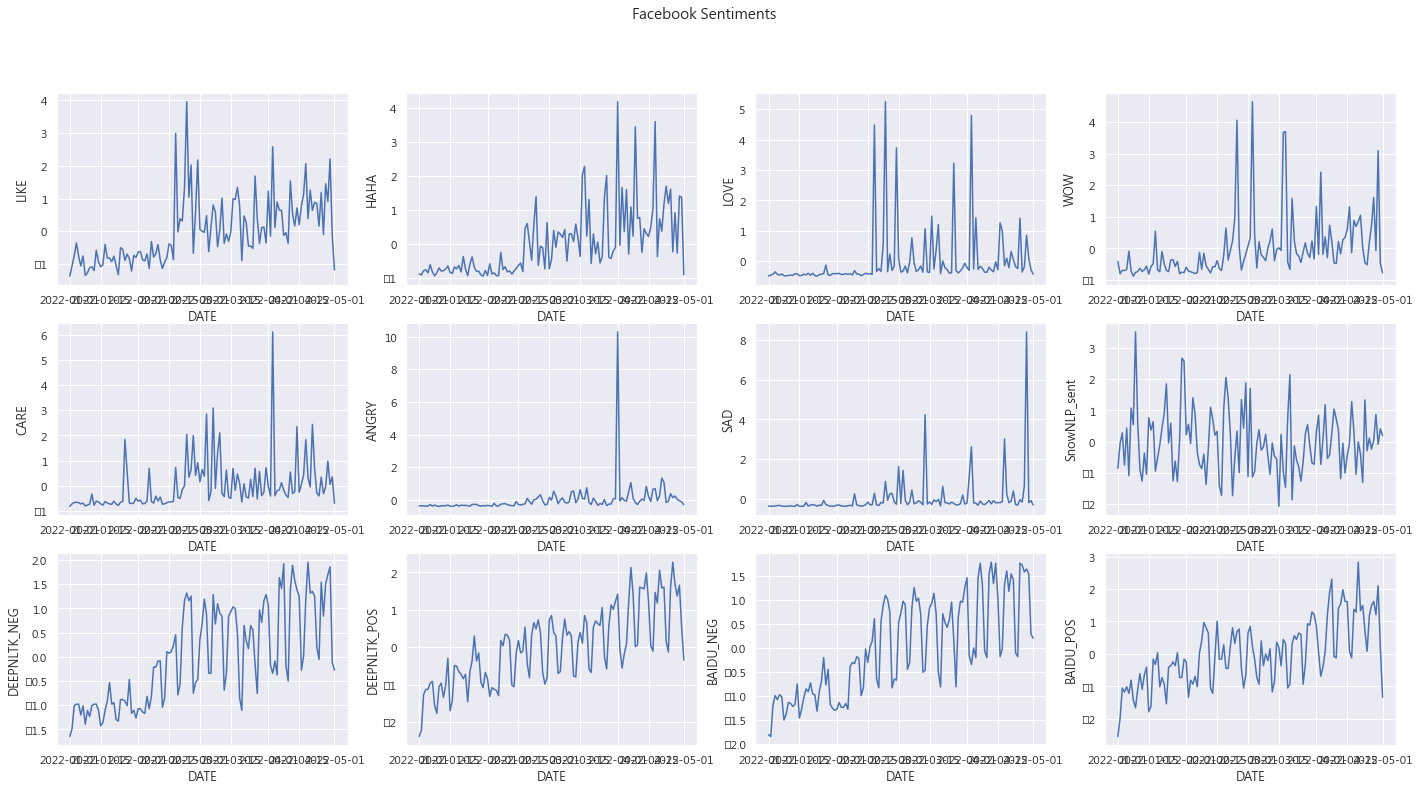

In [274]:
fig, axes = plt.subplots(3, 4, figsize=(24, 12))

fig.suptitle('Facebook Sentiments')

sns.lineplot(ax=axes[0, 0], data=df, x='DATE', y='LIKE')
sns.lineplot(ax=axes[0, 1], data=df, x='DATE', y='HAHA')
sns.lineplot(ax=axes[0, 2], data=df, x='DATE', y='LOVE')
sns.lineplot(ax=axes[0, 3], data=df, x='DATE', y='WOW')

sns.lineplot(ax=axes[1, 0], data=df, x='DATE', y='CARE')
sns.lineplot(ax=axes[1, 1], data=df, x='DATE', y='ANGRY')
sns.lineplot(ax=axes[1, 2], data=df, x='DATE', y='SAD')
sns.lineplot(ax=axes[1, 3], data=df, x='DATE', y='SnowNLP_sent')

sns.lineplot(ax=axes[2, 0], data=df, x='DATE', y='DEEPNLTK_NEG')
sns.lineplot(ax=axes[2, 1], data=df, x='DATE', y='DEEPNLTK_POS')
sns.lineplot(ax=axes[2, 2], data=df, x='DATE', y='BAIDU_NEG')
sns.lineplot(ax=axes[2, 3], data=df, x='DATE', y='BAIDU_POS')

### 活動: 到底為什麼這麼Angry，Sad??
- 對於後面在建模型會帶來什麼問題?

In [287]:
sent_df = df.set_index('DATE').stack().reset_index(name='ZSCORE')
sent_df = sent_df.rename(columns={'level_1':'REACTION_TYPE'})
sent_df

,DATE,REACTION_TYPE,ZSCORE
0,2022-01-01,LIKE,-1.366777
1,2022-01-01,HAHA,-0.891799
2,2022-01-01,LOVE,-0.483491
3,2022-01-01,WOW,-0.413124
4,2022-01-01,CARE,-0.816000
...,...,...,...
1447,2022-05-01,SnowNLP_sent,0.189277
1448,2022-05-01,DEEPNLTK_NEG,-0.276517
1449,2022-05-01,DEEPNLTK_POS,-0.342126
1450,2022-05-01,BAIDU_NEG,0.200727


In [289]:
sent_df.sort_values(['REACTION_TYPE', 'ZSCORE'], ascending= [True, False]).groupby('REACTION_TYPE').head(3)

,DATE,REACTION_TYPE,ZSCORE
1085,2022-04-01,ANGRY,10.286240
1325,2022-04-21,ANGRY,1.328445
1337,2022-04-22,ANGRY,1.066852
1222,2022-04-12,BAIDU_NEG,1.776816
1162,2022-04-07,BAIDU_NEG,1.756610
1246,2022-04-14,BAIDU_NEG,1.756610
1319,2022-04-20,BAIDU_POS,2.826160
1175,2022-04-08,BAIDU_POS,2.301364
1427,2022-04-29,BAIDU_POS,2.099519
1108,2022-04-03,CARE,6.115994


In [293]:
df = pd.read_csv('./data/fanspage_posts/fanspage_posts.csv')
df = df[['NAME', 'TIME', 'MESSAGE', 'POSTID', 'LIKE', 'LOVE', 'HAHA', 'WOW', 'CARE', 'SAD', 'ANGRY']]

In [294]:
df.sort_values('ANGRY', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY
46422,東森財經,2022-04-01 00:51:13,TACO編：比賽車比不過就比國力？\n杰尼龜嗆大陸就是規則！2min猛罵台友狂勸別衝動\n\...,4445191822249519,16861.0,111.0,7364.0,218.0,115.0,64.0,5731.0
38480,今周刊,2021-12-18 00:42:59,快訊！時隔2天的週五（12/17）深夜11點多，王力宏太太李靚蕾在IG上發了一則5000字長...,10159736513223270,8368.0,30.0,134.0,1331.0,172.0,288.0,1267.0


In [295]:
df.sort_values('SAD', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY
35491,東森財經,2022-04-28 15:45:01,龍編：兩眼淚汪汪，看的心都碎了......\n白貓思念過世奶淚崩！悲傷蹭合影討摸摸\n\n影...,4515980455170655,22707.0,2036.0,18.0,28.0,544.0,11658.0,3.0
34592,東森財經,2022-03-13 09:45:00,愛在身編：心疼...既然選擇了牠就請伴牠一生！\n年邁阿金走不動遭棄！暖男照料50天助尊嚴離...,4396009263834442,10177.0,1911.0,2.0,20.0,475.0,6014.0,42.0


In [296]:
df.sort_values('WOW', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY
36964,東森財經,2022-03-18 20:45:00,真嗣拿你沒辦法編：糯米你還有什麼不會的🤣\n聰明汪教科書式顧娃！弟球掉水池1招驚險救\n\n...,4410863479015687,36912.0,792.0,1413.0,4580.0,109.0,13.0,11.0
48562,東森財經,2022-02-24 10:45:41,太陽打從西編：大家真的要小心自己的隨身物品ㄟ\n正妹腳邊行李1秒消失！他3動作連偷震驚百萬人...,4349243101844392,12516.0,63.0,184.0,4525.0,20.0,31.0,120.0


In [297]:
df.sort_values('HAHA', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY
36214,東森財經,2022-04-09 18:45:01,在權志龍身編：真的是辛苦了～\n醫護爆笑催做核酸！喊下樓免化妝：這沒彭于晏\n\n影片來源：抖音,4467800656655302,27480.0,130.0,29778.0,91.0,87.0,17.0,18.0
35975,東森財經,2022-04-01 20:45:00,大編：這確定沒有先全麻過嗎？\n睡死汪遭飼主偷餵藥！拉舌倒粉牠全程無感\n\n影片來源：初壹...,4447061035395931,26709.0,154.0,24271.0,319.0,46.0,7.0,19.0


In [298]:
df.sort_values('LIKE', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY
46752,東森財經,2022-02-25 22:20:00,魅力無編：如果是你的孩子浪費食物，你會怎麼做？\n童浪費食物隨意扔！父1舉動獲讚最佳身教\n...,4355562004545835,78070.0,1189.0,308.0,440.0,383.0,267.0,192.0
47073,東森財經,2022-04-03 23:45:00,TACO編：你們有被警察暖心的舉動感動到嗎？QQ\n見嬤孫只點1盤菜 暖警霸氣掏錢幫加菜\n...,4451661388269229,76059.0,10734.0,42.0,43.0,531.0,54.0,24.0
